# Processing Synthetic TTS Data

In this notebook, the synthetic data generated using Google's and Microsoft's TTS systems is processed, such that it can be used as data for the speech generation model.

The data consists of 16 MP3 files, from 5 speakers with slight alterations in pitch and velocity. Each file contains the 55 words that overlap between the first Harry Potter chapter and the VariaNTS corpus, read out by the TTS system.

Therefore, we have to split each file at silence and store them as WAV.

In [187]:
from pathlib import Path
import re
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
from pydub import AudioSegment, silence
import seaborn as sns

from utils import *

In [149]:
data_dir = Path.home() / 'data'

input_dir = data_dir / 'VariaNTS_HarryPotter_TTS'

output_dir = data_dir / 'VariaNTS_HarryPotter_TTS_split'

export_FR = 16000

# The words that were read by the TTS systems
words = ['boel', 'doel', 'hand', 'stijf', 'feest', 'steen', 'dag', 'weg', 'kan', 'zin', 'vorm', 'heer', 'dood', 'kant', 'bril', 'rest', 'land', 'snel', 'dier', 'hoofd', 'raam', 'meer', 'goed', 'heel', 'los', 'greep', 'tijd', 'stad', 'kind', 'half', 'kalm', 'lang', 'mot', 'kneep', 'keel', 'klein', 'vroeg', 'man', 'bed', 'brief', 'wind', 'hoop', 'stuur', 'kwaad', 'licht', 'werk', 'paar', 'neus', 'vol', 'mond', 'zet', 'keer', 'laat', 'wel', 'zoon']

## Automated solution for all files

Algorithm:

1. Read MP3
2. Convert to Mono
3. Split on silence (given parameters)
4. Assert number of resulting audios is equal to the words (== 55)
5. Downsample each audio to 16kHz and export as WAV
6. Repeat for remaining MP3s

In [242]:
i = 0

for fn in tqdm(sorted(os.listdir(input_dir))):
    if not fn.endswith('.mp3'): 
        continue
    
    speaker_dir = f'p{i+17:02}/p{i+17:02}_words'
    
    audio = AudioSegment.from_file(input_dir / fn)

    # Convert to mono (taking the first channel only)
    audio, _ = audio.split_to_mono()

    # Split the audio into individual words using the silence that's between
    # the words
    split_audios = silence.split_on_silence(audio, min_silence_len=150, silence_thresh=-500, keep_silence=50)
    
    if len(split_audios) != 55:
        print(f'Failed for file {fn}')
        continue

    os.makedirs(output_dir / speaker_dir, exist_ok = True)

    for j, split_audio in enumerate(split_audios):
        split_audio.set_frame_rate(export_FR)
        split_audio.export(
            output_dir / speaker_dir / f'{words[j]}.wav',
            format='wav'
        )

    i += 1


100%|██████████| 16/16 [00:26<00:00,  1.63s/it]


## For testing purposes: only for a single file

In [193]:
fn = sorted(os.listdir(input_dir))[1]
fn

'Google_A_female_PitchLow.mp3'

In [194]:
audio = AudioSegment.from_file(input_dir / fn)
# Convert to mono (taking the first channel only)
audio, _ = audio.split_to_mono()

Silent sections found at milliseconds:
[[432, 656], [1007, 1275], [1597, 1899], [2284, 2713], [3101, 3391], [3836, 4067], [4352, 4657], [4925, 5229], [5506, 5751], [6084, 6384], [6723, 6985], [7305, 7542], [7906, 8204], [8532, 8818], [9195, 9421], [9808, 10065], [10440, 10736], [11129, 11352], [11739, 12018], [12211, 12671], [13021, 13235], [13577, 13853], [14123, 14459], [14754, 14965], [15296, 15622], [15909, 16209], [16533, 16840], [17176, 17484], [17812, 18136], [18355, 18799], [19143, 19355], [19674, 19905], [20182, 20519], [20734, 21029], [21322, 21579], [21939, 22250], [22503, 22805], [23128, 23356], [23646, 23933], [24178, 24597], [24955, 25279], [25461, 25756], [26169, 26451], [26788, 27055], [27295, 27419], [27428, 27713], [27977, 28345], [28644, 28880], [29277, 29639], [30276, 30573], [30865, 31169], [31473, 31700], [32043, 32327], [32642, 32881], [33249, 33456]]


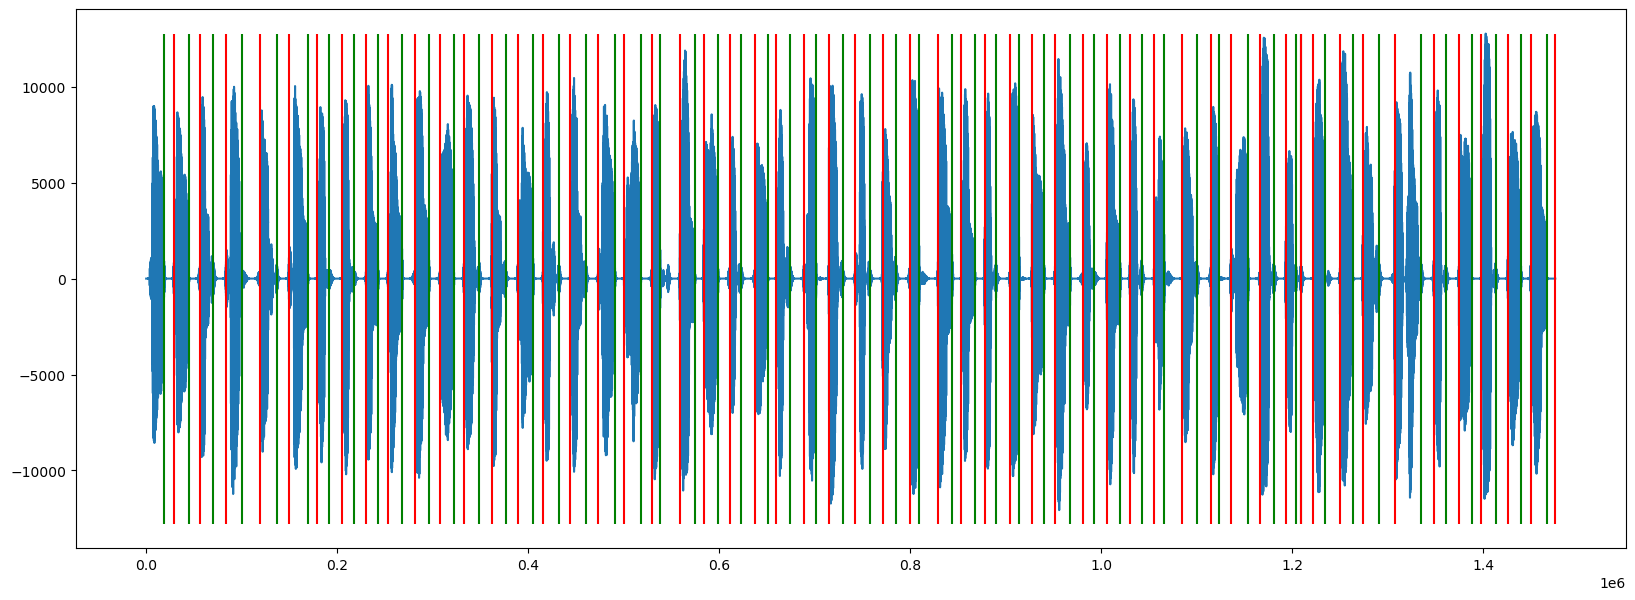

In [195]:
plt.figure(figsize=(20,7))
silence_idx = silence.detect_silence(audio, min_silence_len=100, silence_thresh=-50)
print('Silent sections found at milliseconds:')
print(silence_idx)

audio_data = np.array(audio.get_array_of_samples())
if audio.channels == 2:
    res_data = audio_data.reshape(int(audio.frame_count()), 2)
    plt.plot(res_data[:,0], label='Channel 1')
    plt.plot(res_data[:,1], label='Channel 2')
else:
    plt.plot(np.linspace(0, audio.frame_count(), audio_data.shape[0]), audio_data)
plt.vlines([(section[0]/1000)*audio.frame_rate for section in silence_idx], ymin=-audio.max, ymax=audio.max, color='g')
plt.vlines([(section[1]/1000)*audio.frame_rate for section in silence_idx], ymin=-audio.max, ymax=audio.max, color='r')
plt.show()

display(audio)

In [235]:
split_audios = silence.split_on_silence(audio, min_silence_len=45, silence_thresh=-80, keep_silence=50)
len(split_audios)

55

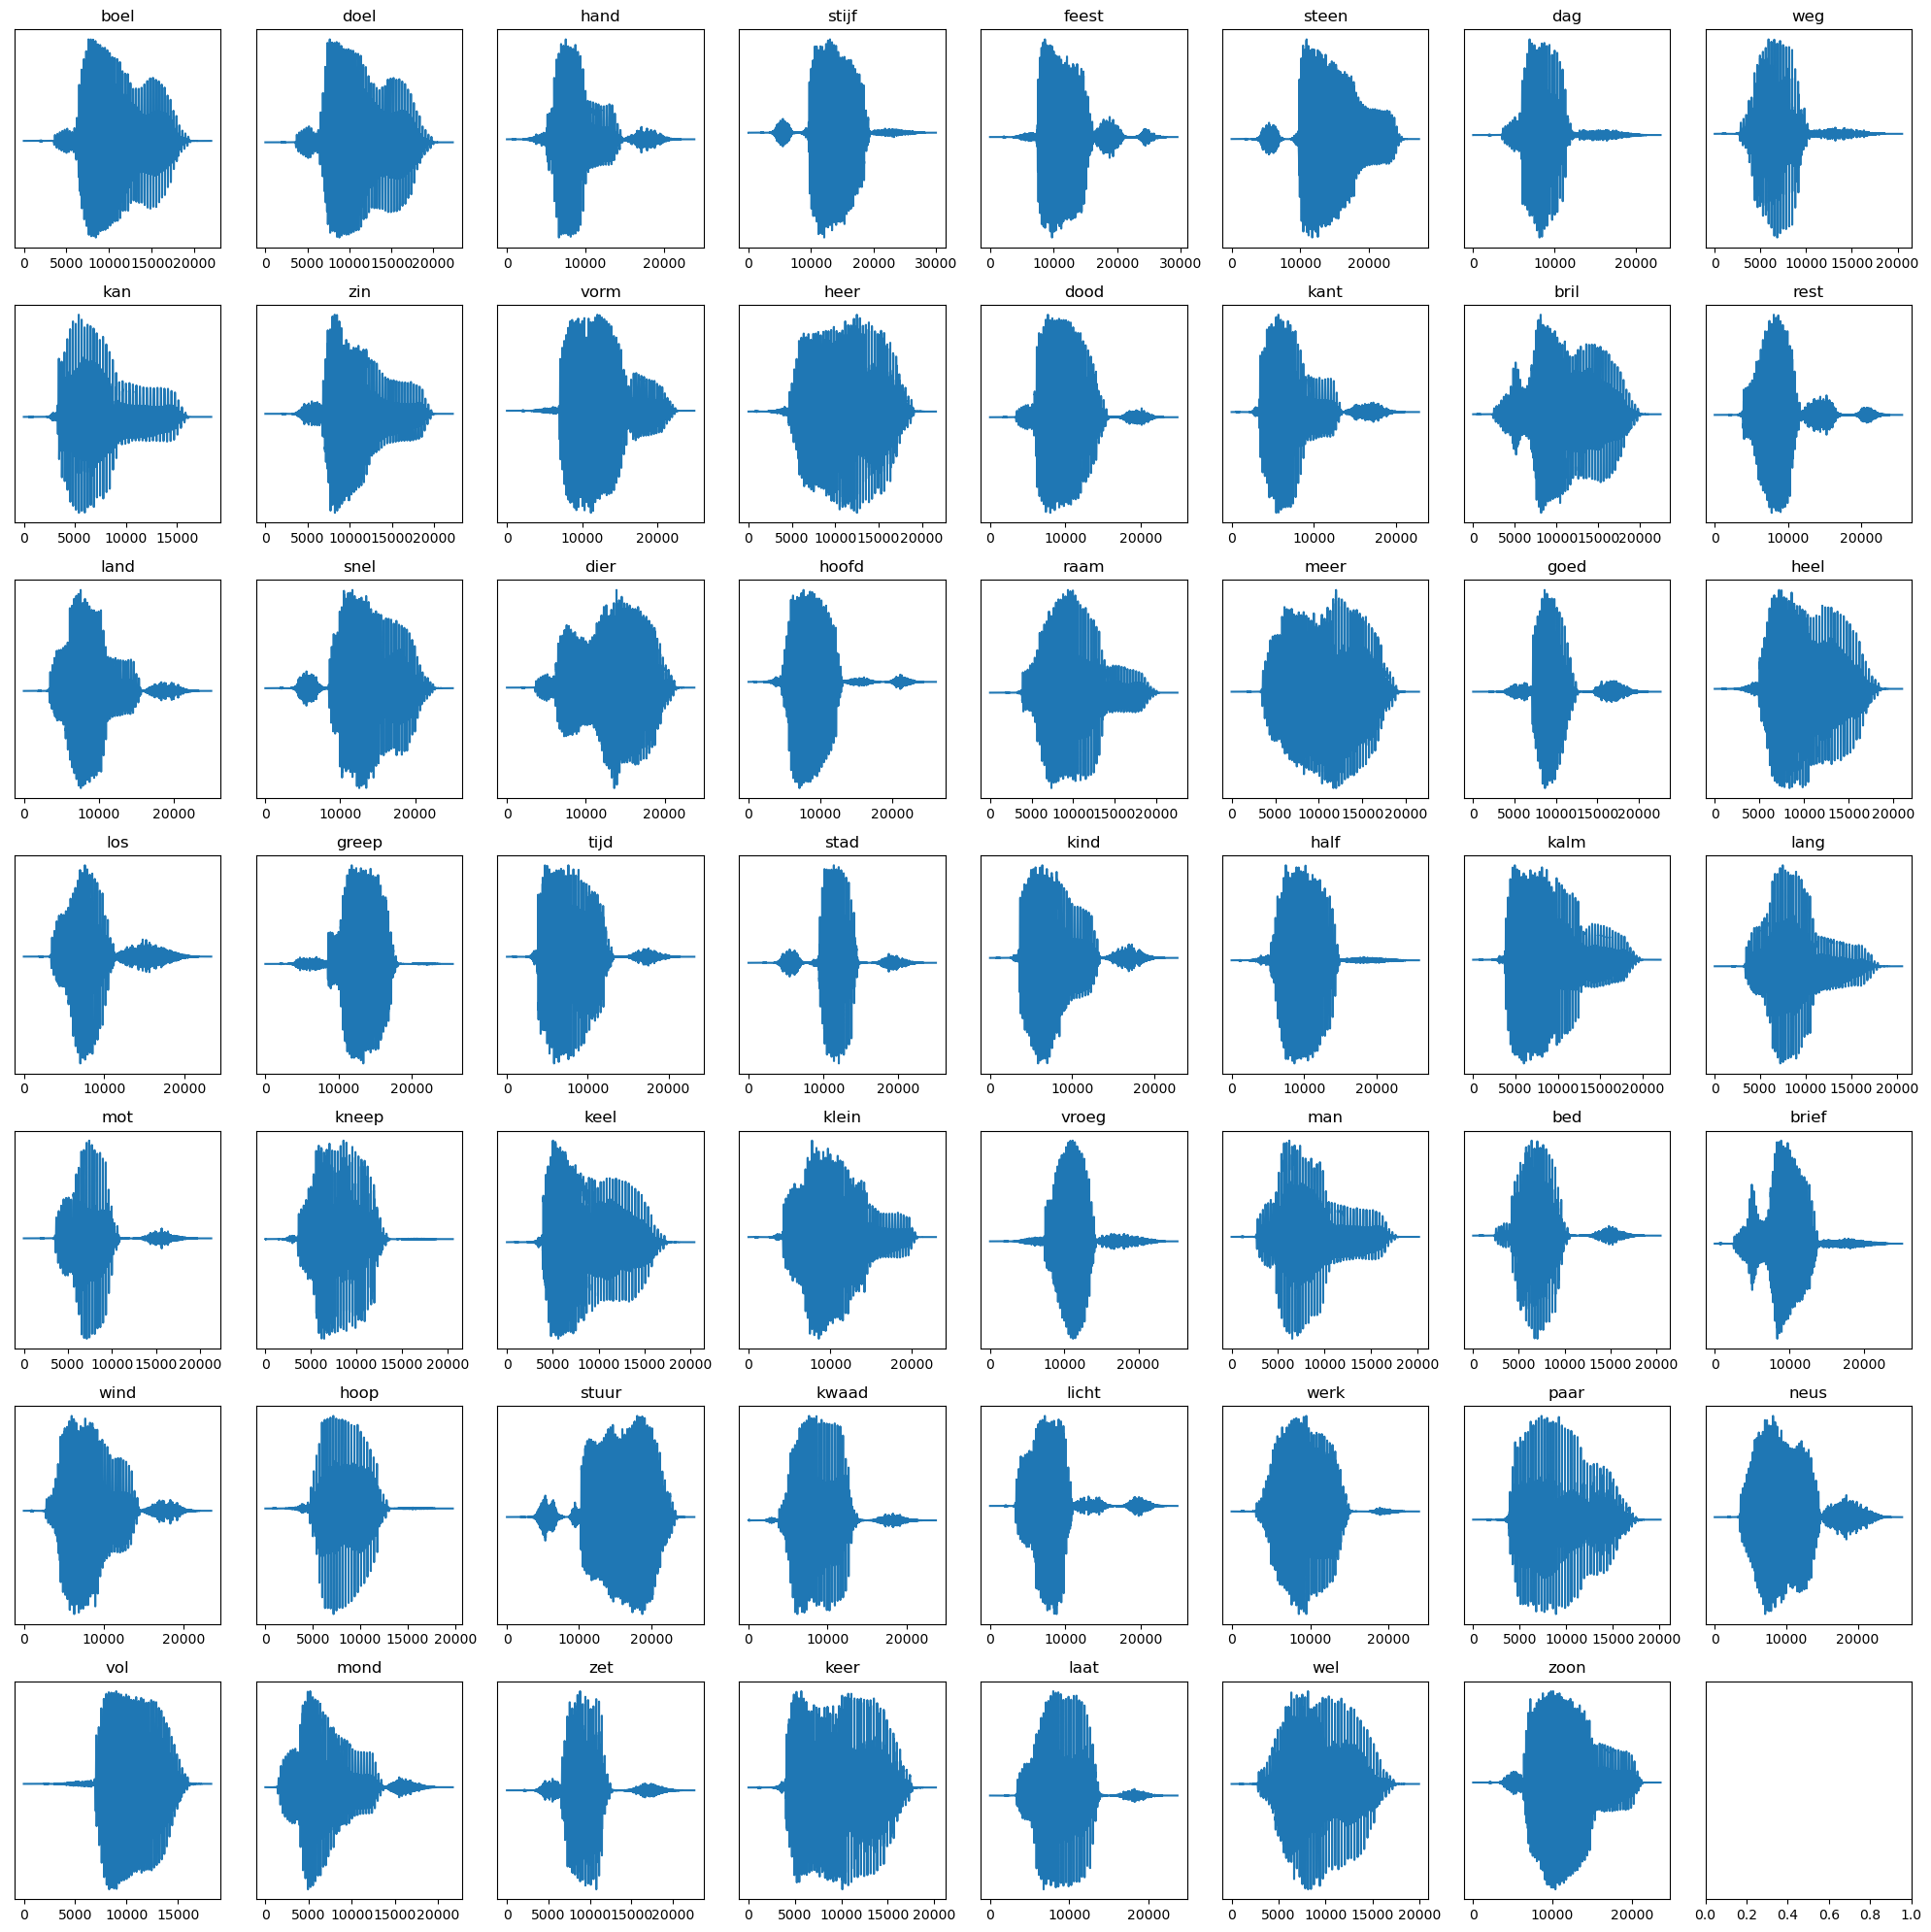

In [236]:
nrows, ncols = 7, 8
fig, axs = plt.subplots(nrows, ncols, figsize=(20,20))

for i,row in enumerate(axs):
    for j,col in enumerate(row):
        idx = i * ncols + j
        if idx < len(split_audios):
            col.set_title(words[idx])
            col.plot(split_audios[idx].get_array_of_samples())
        col.set_yticks([])

plt.tight_layout()
plt.show()

## Merge original and synthetic speakers

To combine the 16 original speakers from the VariaNTS corpus with the 16 synthetic speakers, the easiest way is to just drag and drop the files from both respective directories to a new directory, or use 

```
$ cp speaker_dir/* new_combined_dir/
``` 

in your shell which is typically faster than Python